## **GNN on connectome **

We will go through a tutorial with toy data

and then a link for EEG data with explainability (optional)

Nevertheless, this is the standard 10-20 settings for the electrode:


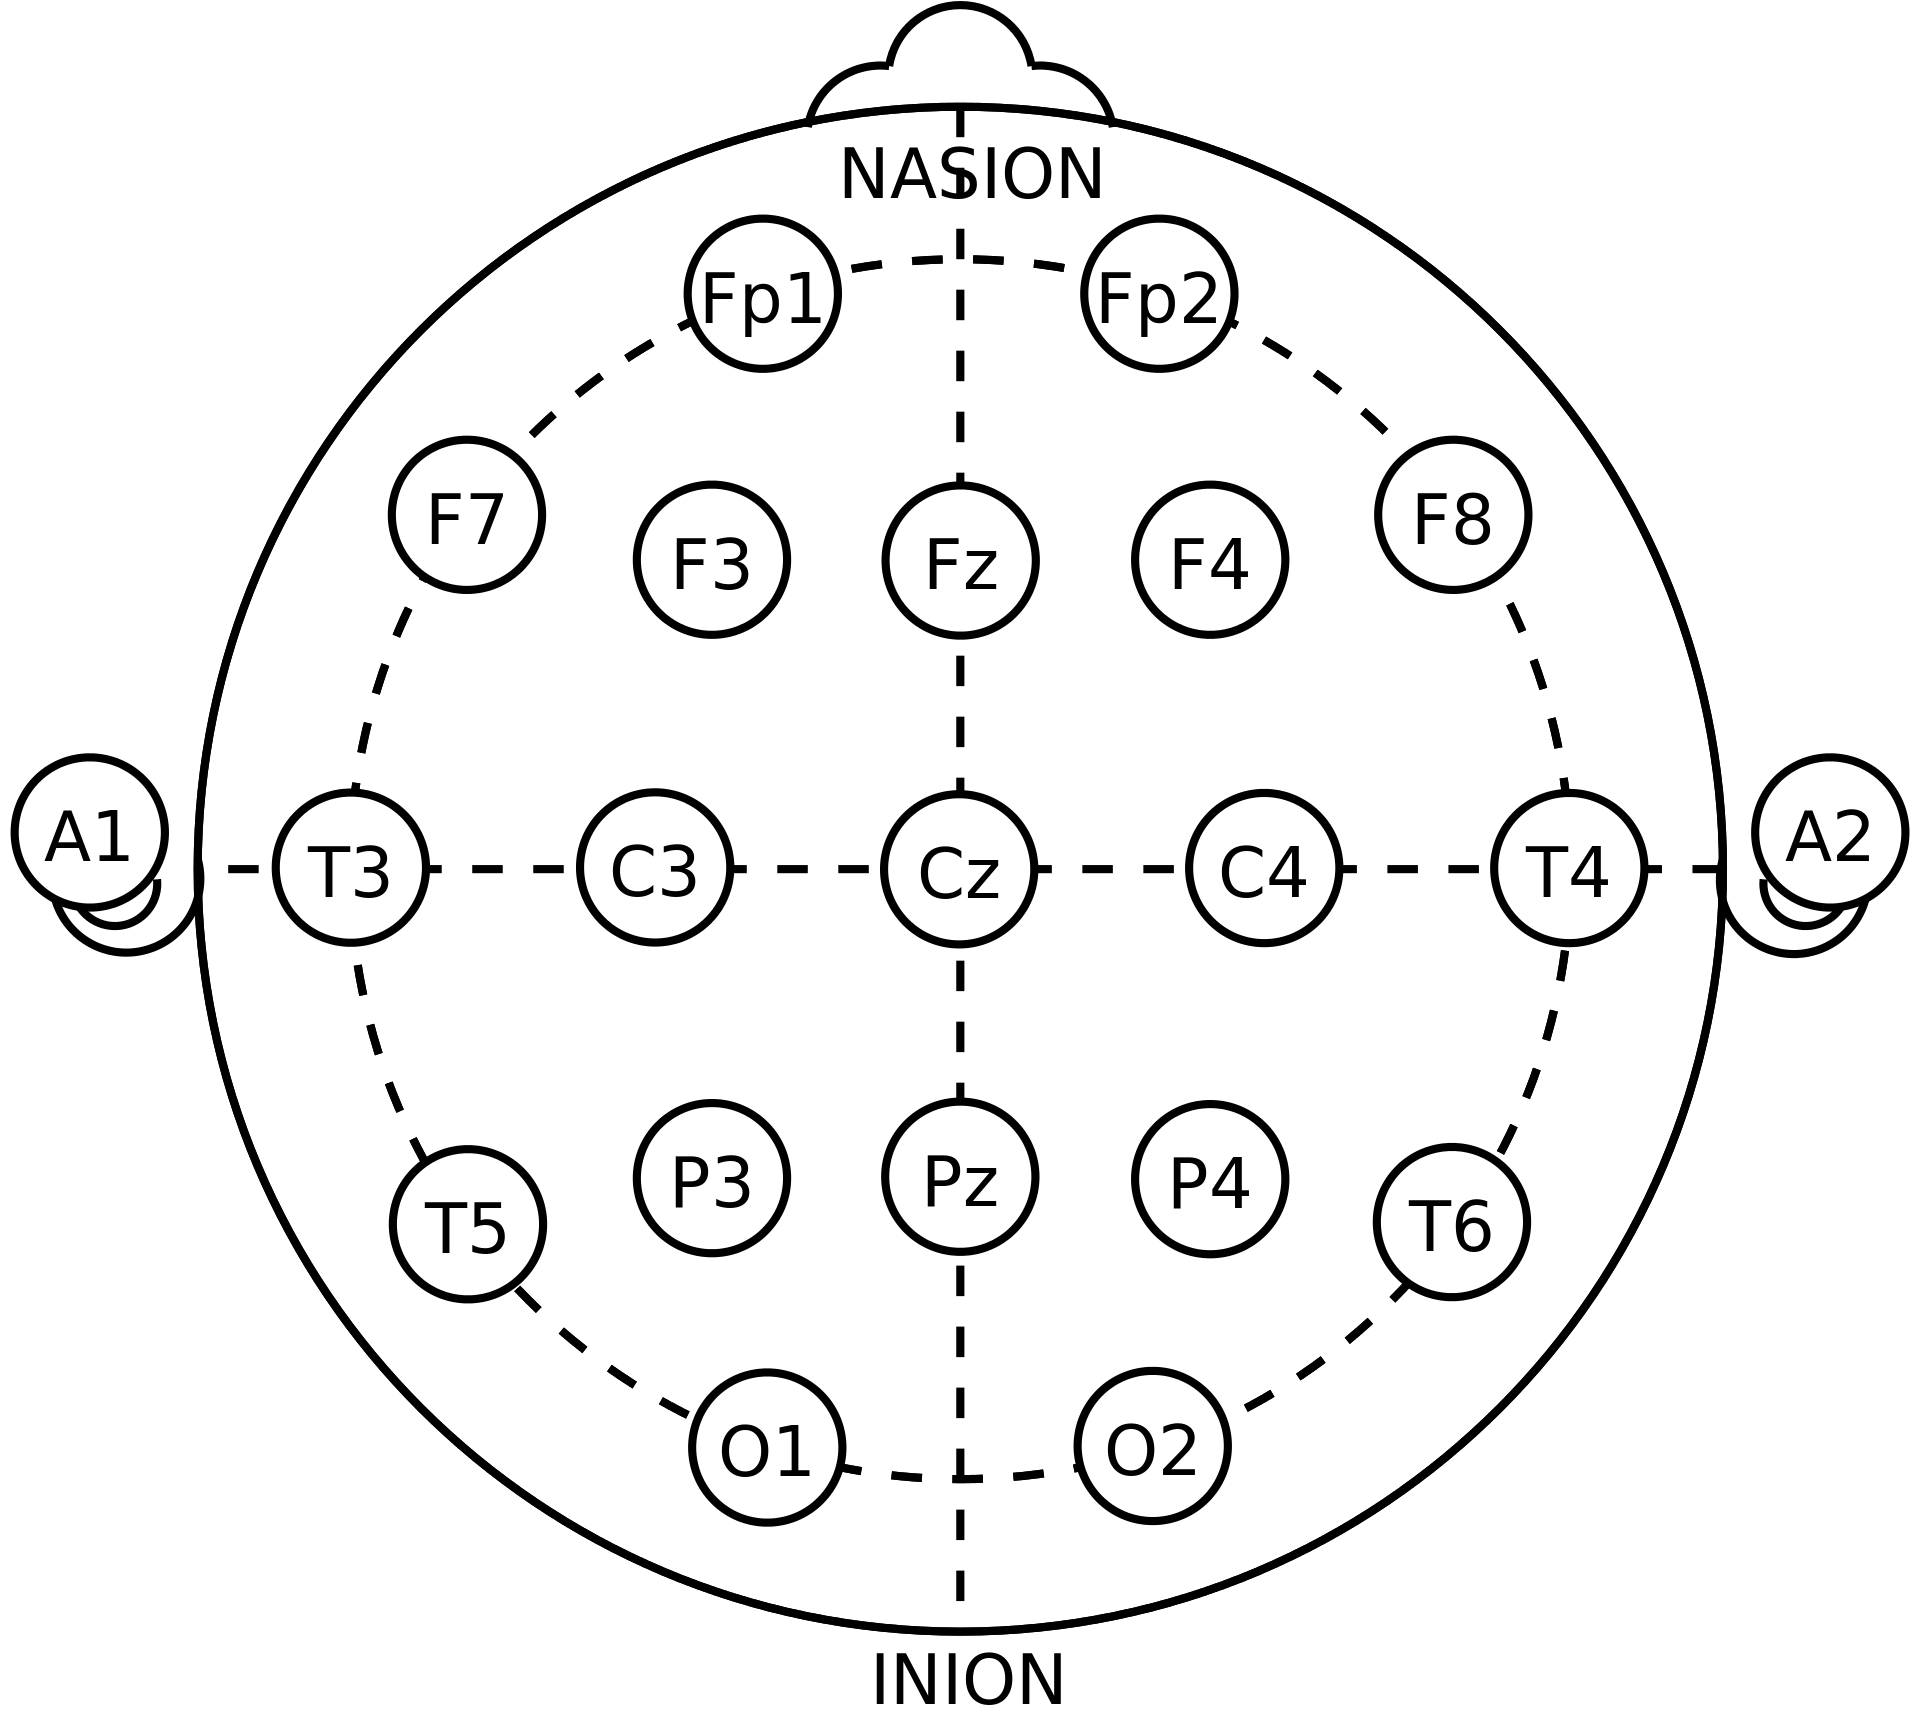

## **Understanding GCN concept by building a simple graph . . .**


<div>
<center><img src="https://miro.medium.com/max/1508/1*68Gcr70UTpdaX7THbZSEcA.png" width="600" /></center>
</div>

### Defining the graph and it's features

So, we build the adjacency matrix A from the **LEFT** figure (graph woth 5 nodes):

In [1]:
import numpy as np
#############################
# Exercice 1: Complete the last three rows of the matrix.
#############################
A = np.matrix([
    [0, 1, 1, 1, 0],
    [1, 0, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 0, 0, 0, 0],
    [0, 1, 1, 0, 0]
    ],dtype=float
)

Now, we generate 2 features for each node based on the index. This makes it easy to confirm the matrix calculations manually later.

In [2]:
X = np.matrix([
            [i, -i]
            for i in range(A.shape[0])
        ], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.],
        [ 4., -4.]])

In [3]:
A*X

matrix([[ 6., -6.],
        [ 6., -6.],
        [ 5., -5.],
        [ 0.,  0.],
        [ 3., -3.]])

### Applying the simple propagation rule for the input layer:

Now we will try to implement the layer equation defined in theory. To make it easier, we will ommit the normalization part, as it is implicit in the implementation of the model from Pytorch Geometric that we will use and it is not necessary to get the intuition of how GCN works.


### ` f(Hⁱ, A) = σ(A Hⁱ Wⁱ) `

*   H⁰ = X = input features
*   AH⁰W⁰ = AXW⁰ = AX
*   W = I






In [4]:
H_0 = X

In [5]:
W = np.identity(2)

In [6]:
H_1 = A * H_0 * W
H_1

matrix([[ 6., -6.],
        [ 6., -6.],
        [ 5., -5.],
        [ 0.,  0.],
        [ 3., -3.]])

As you can observe, the representation of each node (each row) is now a sum of its neighbors features!

In other words, the graph convolutional layer represents each node as an aggregate of its neighborhood, as we saw on theory slides.

### Adding self loops

If you look carefuly to the previous representation of each node after the popagation rule, the node itself is not taken into account. Thus, that is the reason why we need to add self loops to the adjacency matrix, conforming the Â matrix.


In [7]:
#############################
# Exercice 2: Build identity matrix I using np.identity()
#             Sum I with A matrix to build Â
#############################

I  = np.identity(A.shape[0])
I

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [8]:
A_hat = A + I
A_hat

matrix([[1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1.],
        [1., 0., 0., 1., 0.],
        [0., 1., 1., 0., 1.]])

In [9]:
# Now run again the GCN equation and observe the new output
H_1 = A_hat * H_0 * W
H_1

matrix([[ 6., -6.],
        [ 7., -7.],
        [ 7., -7.],
        [ 3., -3.],
        [ 7., -7.]])

As you observe, now we have taken into account the node itself when computing the aggregation of local neightbours by A * X.

### Why do we need to normalize?




Here we intent to show what happens without normalizing. Then, we will show whats the same output when applying normalization.

> So, lets try to apply the GCN equation for 1000 epochs:

In [10]:
H_n = H_1
for i in range(1000):
    H_n = A_hat * H_n * W

print(H_n)

[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]


> You can observe that the output features for epoch 1000 are nan... So, let's try to normalize before and repeat the operation.
>
> **Q:** WHY DO YOU THINK IT HAPPENS?

In [11]:
A_hat

matrix([[1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1.],
        [1., 0., 0., 1., 0.],
        [0., 1., 1., 0., 1.]])

In [12]:
D = np.array(A_hat.sum(1))
D

array([[4.],
       [4.],
       [4.],
       [2.],
       [3.]])

In [13]:
D_inv_half = np.power(D, -0.5).flatten()
D_mat = np.diag(D_inv_half)
# SYMMETRIC NORMALIZATION = D^-1/2 * (H) * D^-1/2
aux = D_mat.dot(A_hat)
norm_A_hat = aux.dot(D_mat)
norm_A_hat

matrix([[0.25      , 0.25      , 0.25      , 0.35355339, 0.        ],
        [0.25      , 0.25      , 0.25      , 0.        , 0.28867513],
        [0.25      , 0.25      , 0.25      , 0.        , 0.28867513],
        [0.35355339, 0.        , 0.        , 0.5       , 0.        ],
        [0.        , 0.28867513, 0.28867513, 0.        , 0.33333333]])

In [14]:
H_1_norm = norm_A_hat * H_0 * W
H_1_norm

matrix([[ 1.81066017, -1.81066017],
        [ 1.90470054, -1.90470054],
        [ 1.90470054, -1.90470054],
        [ 1.5       , -1.5       ],
        [ 2.19935874, -2.19935874]])

In [15]:
H_n = H_1_norm
for i in range(1000):
    H_n = norm_A_hat * H_n * W

print(H_n)

[[ 2.02009928 -2.02009928]
 [ 2.02009928 -2.02009928]
 [ 2.02009928 -2.02009928]
 [ 1.4284259  -1.4284259 ]
 [ 1.7494573  -1.7494573 ]]


> Now, as you observe we still can get good results after iterating for 1000 epochs.


The explanation is that normalizing avoid numbers to be higher than one in all the multiplications, and so we need to do it in order to solve possible problems such as exploding gradients or having weights which are too big.

## **Let's use the GNN with brain connectivity data (OPTIONAL)**

We can use it to classify fucntional connectivity data from EEG or fMRI. For example from schizophrenia or people experiencing epileptic seizures.

Here is a public dataset with EEG and epileptic seizures recording:
https://physionet.org/content/chbmit/1.0.0/

Use the following code based geometric pytorch for the GNNs and GATv2Lightning for explainability:
https://github.com/szmazurek/sano_eeg


